In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import os

# 1.1 Baseline Setup


#### 1. Configurations


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 5
learning_rate = 0.001

#### 2. CIFAR-10 Dataset


In [3]:
transform = transforms.Compose([
    transforms.Resize(224),   # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes


100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s]


#### 3. Load Pre-trained ResNet-152 + Loss and Optimizer


In [4]:
model = models.resnet152(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # CIFAR-10 has 10 classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:04<00:00, 54.0MB/s]


#### 4. Training Loop


In [ ]:
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch [1/5], Train Acc: 83.10%, Val Acc: 82.72%
Epoch [2/5], Train Acc: 83.29%, Val Acc: 84.23%
Epoch [3/5], Train Acc: 83.66%, Val Acc: 84.97%
Epoch [4/5], Train Acc: 83.75%, Val Acc: 85.23%
Epoch [5/5], Train Acc: 84.14%, Val Acc: 83.81%


#### 5. Plot Results


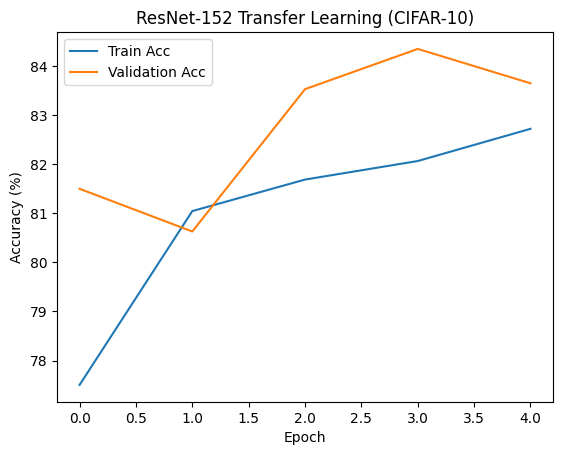

In [ ]:
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('ResNet-152 Transfer Learning (CIFAR-10)')
plt.show()

# 1.2: Residual Connections in Practice.

In [ ]:


# Patch forward() to disable skip connections
def forward_no_skip(self, x):
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out)
      out = self.bn2(out)
      out = self.relu(out)

      out = self.conv3(out)
      out = self.bn3(out)

      # no residual addition
      out = self.relu(out)
      return out

def remove_skip_connections(model, layers_to_modify=[2, 3]):
      """
      Monkey-patch Bottleneck blocks in given layers to remove skip connections.
      layers_to_modify: [0]=layer1, [1]=layer2, [2]=layer3, [3]=layer4
      """
      layers = [model.layer1, model.layer2, model.layer3, model.layer4]
      for idx in layers_to_modify:
          layer = layers[idx]
          for block in layer:
              block.forward = forward_no_skip.__get__(block, block.__class__)
      return model



In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

# Use new weights API
model = resnet152(weights=ResNet152_Weights.DEFAULT)

# Remove skips from shallow layers
model = remove_skip_connections(model, layers_to_modify=[0, 1])

# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze modified layers so they can adapt
for param in model.layer1.parameters():
    param.requires_grad = True
for param in model.layer2.parameters():
    param.requires_grad = True

# Replace FC head
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)


In [ ]:
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch [1/5], Train Acc: 12.18%, Val Acc: 13.45%
Epoch [2/5], Train Acc: 13.34%, Val Acc: 13.01%
Epoch [3/5], Train Acc: 13.39%, Val Acc: 13.38%
Epoch [4/5], Train Acc: 13.35%, Val Acc: 14.01%
Epoch [5/5], Train Acc: 13.22%, Val Acc: 14.05%


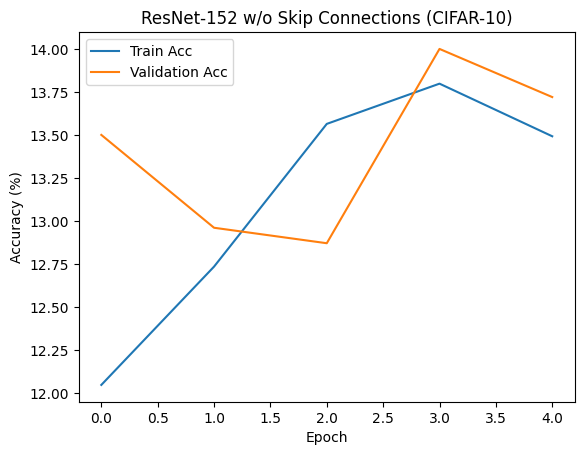

In [ ]:
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('ResNet-152 w/o Skip Connections (CIFAR-10)')
plt.show()

# 1.3 - Feature hierarchies: extract features from early/mid/late layers and visualize with UMAP/t-SNE


In [ ]:
import random
import os
import umap
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet152, ResNet152_Weights
try:
    import umap
    HAS_UMAP = True
except Exception:
    from sklearn.manifold import TSNE
    print("No UMAP Lib")
    HAS_UMAP = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
MAX_SAMPLES = 1000   # how many images to collect features from (speed vs quality)
SAVE_DIR = "results/1.3"
os.makedirs(SAVE_DIR, exist_ok=True)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # use ImageNet stats for pretrained models
                         (0.229, 0.224, 0.225))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# optionally use a random subset for speed
indices = list(range(len(dataset)))
random.shuffle(indices)
indices = indices[:MAX_SAMPLES]
subset = Subset(dataset, indices)
loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
model = resnet152(weights=ResNet152_Weights.DEFAULT)
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# We'll capture outputs (feature maps) from layer1, layer2, layer3, and the pre-pool penultimate representation
features = {"layer1": [], "layer2": [], "layer3": [], "avgpool": []}
torch.cuda.empty_cache()
labels_list = []

def make_hook(name):
    def hook(module, input, output):
        # output shape: (B, C, H, W) for conv blocks; for avgpool it's (B, C, 1, 1)
        features[name].append(output.detach().cpu())
    return hook

# register hooks
model.layer1.register_forward_hook(make_hook("layer1"))
model.layer2.register_forward_hook(make_hook("layer2"))
model.layer3.register_forward_hook(make_hook("layer3"))
# capture the tensor just before the final fc (after avgpool)
model.avgpool.register_forward_hook(make_hook("avgpool"))

# -----------------------------
# Run forward passes and collect features
# -----------------------------
with torch.no_grad():
    for imgs, labs in loader:
        imgs = imgs.to(device, non_blocking=True)
        _ = model(imgs)   # hooks populate `features`
        labels_list.append(labs)

# concat and process features
labels = torch.cat(labels_list).numpy()  # shape (N,)

def pool_and_flatten(tensor_list):
    t = torch.cat(tensor_list, dim=0)  # (N, C, H, W)
    if t.dim() == 4:
        t = t.mean(dim=[2,3])  # global average pool
    return t.numpy()


feat_layer1 = pool_and_flatten(features["layer1"])   # early features
feat_layer2 = pool_and_flatten(features["layer2"])   # mid features
feat_layer3 = pool_and_flatten(features["layer3"])   # late features (before avgpool)
feat_penult = pool_and_flatten(features["avgpool"])  # penultimate pooled features

print("Collected features shapes:", feat_layer1.shape, feat_layer2.shape, feat_layer3.shape, feat_penult.shape)
# note: feat_penult should be (N, 2048) typically

Collected features shapes: (1000, 256) (1000, 512) (1000, 1024) (1000, 2048)


In [ ]:
# -----------------------------
# Dimensionality reduction and plotting
# -----------------------------
def embed_and_plot(X, labels, title, fname):
    """
    X: numpy array (N, D)
    labels: numpy array (N,)
    """
    if HAS_UMAP:
        reducer = umap.UMAP(n_components=2, random_state=42)
        Z = reducer.fit_transform(X)
    else:
        tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca')
        Z = tsne.fit_transform(X)

    plt.figure(figsize=(6,6))
    num_classes = len(np.unique(labels))
    cmap = plt.get_cmap('tab10')
    for c in range(num_classes):
        idx = labels == c
        plt.scatter(Z[idx,0], Z[idx,1], s=6, label=str(c), alpha=0.7, color=cmap(c))
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.title(title)
    plt.tight_layout()
    outpath = os.path.join(SAVE_DIR, fname)
    plt.savefig(outpath, dpi=150)
    plt.close()
    print("Saved:", outpath)

# run on a few layers
embed_and_plot(feat_layer1, labels, "ResNet layer1 features (GAP -> 2D)", "layer1_umap.png")
embed_and_plot(feat_layer2, labels, "ResNet layer2 features (GAP -> 2D)", "layer2_umap.png")
embed_and_plot(feat_layer3, labels, "ResNet layer3 features (GAP -> 2D)", "layer3_umap.png")
embed_and_plot(feat_penult, labels, "ResNet penultimate features (avgpool -> 2D)", "penult_umap.png")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: results/1.3/layer1_umap.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: results/1.3/layer2_umap.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: results/1.3/layer3_umap.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: results/1.3/penult_umap.png



# 1.4: Transfer Learning and Generalization



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet152, ResNet152_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:06<00:00, 28.1MB/s]


In [ ]:
def train_model(model, optimizer, criterion, num_epochs=5, name="experiment"):
    train_acc_hist, val_acc_hist = [], []
    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        train_acc_hist.append(train_acc)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        val_acc_hist.append(val_acc)

        print(f"[{name}] Epoch [{epoch+1}/{num_epochs}], "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return train_acc_hist, val_acc_hist

## Experiment 1: Pretrained only

In [ ]:
# Pretrained, only classification head
model = resnet152(weights=ResNet152_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

train_model(model, optimizer, criterion, num_epochs=5, name="Pretrained_FC")


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:01<00:00, 143MB/s]


[Pretrained_FC] Epoch [1/5], Train Acc: 78.61%, Val Acc: 83.31%
[Pretrained_FC] Epoch [2/5], Train Acc: 83.63%, Val Acc: 84.03%
[Pretrained_FC] Epoch [3/5], Train Acc: 84.96%, Val Acc: 85.08%
[Pretrained_FC] Epoch [4/5], Train Acc: 85.57%, Val Acc: 84.77%
[Pretrained_FC] Epoch [5/5], Train Acc: 85.94%, Val Acc: 84.66%


([78.606, 83.632, 84.96, 85.572, 85.942], [83.31, 84.03, 85.08, 84.77, 84.66])

## Experiment 2: Random initialisation

In [ ]:
# Random initialization
model = resnet152(weights=None)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, num_epochs=5, name="Scratch")


[Scratch] Epoch [1/5], Train Acc: 35.99%, Val Acc: 48.71%
[Scratch] Epoch [2/5], Train Acc: 55.96%, Val Acc: 58.21%
[Scratch] Epoch [3/5], Train Acc: 65.51%, Val Acc: 68.08%
[Scratch] Epoch [4/5], Train Acc: 73.78%, Val Acc: 72.90%
[Scratch] Epoch [5/5], Train Acc: 78.68%, Val Acc: 77.30%


([35.992, 55.964, 65.51, 73.78, 78.676], [48.71, 58.21, 68.08, 72.9, 77.3])

## Pretrained, last block + FC fine-tuned

In [ ]:
# Pretrained, fine-tune last block (layer4) + FC
model = resnet152(weights=ResNet152_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():  # unfreeze last block
    param.requires_grad = True

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)

train_model(model, optimizer, criterion, num_epochs=5, name="Pretrained_Layer4")


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:06<00:00, 37.2MB/s]


[Pretrained_Layer4] Epoch [1/5], Train Acc: 86.57%, Val Acc: 91.23%
[Pretrained_Layer4] Epoch [2/5], Train Acc: 94.25%, Val Acc: 91.46%
[Pretrained_Layer4] Epoch [3/5], Train Acc: 97.04%, Val Acc: 91.58%
[Pretrained_Layer4] Epoch [4/5], Train Acc: 97.98%, Val Acc: 91.97%
[Pretrained_Layer4] Epoch [5/5], Train Acc: 98.65%, Val Acc: 92.02%


([86.568, 94.246, 97.036, 97.98, 98.652], [91.23, 91.46, 91.58, 91.97, 92.02])

# 1.5: Optional Experiments

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import umap


## Use a 10% subset of the dataset

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
subset_ratio = 0.1      # use 10% of dataset
batch_size = 64
num_epochs = 3          # fewer epochs for quick runs
lr = 0.001

In [10]:
transform = transforms.Compose([
    transforms.Resize((224,224)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_dataset = Subset(train_dataset, range(int(len(train_dataset) * subset_ratio)))
val_dataset = Subset(val_dataset, range(int(len(val_dataset) * subset_ratio)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

classes = torchvision.datasets.CIFAR10(root='./data', train=False).classes

## Functions

In [11]:
def train_model(model, train_loader, val_loader, num_epochs=3, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    for epoch in range(num_epochs):
        # Train
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
        train_acc = 100 * correct / total

        # Validate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = outputs.max(1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# Extract features from intermediate layer
def extract_features(model, dataloader, device, layer_name="avgpool"):
    feats, labels = [], []

    def hook_fn(module, input, output):
        feats.append(output.detach().cpu())

    handle = dict(model.named_modules())[layer_name].register_forward_hook(hook_fn)

    model.eval()
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            _ = model(images)  # forward pass triggers hook
            labels.extend(lbls.numpy())

    handle.remove()
    feats = torch.cat(feats, dim=0)
    feats = feats.view(feats.size(0), -1)  # flatten
    labels = np.array(labels)
    return feats, labels

# (a) t-SNE vs UMAP
def tsne_vs_umap(model, val_loader):
    features, labels = extract_features(model, val_loader, device, "avgpool")

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='tab10', s=5)
    plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("t-SNE projection (penultimate layer)")
    plt.show()

    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_results = reducer.fit_transform(features)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(umap_results[:,0], umap_results[:,1], c=labels, cmap='tab10', s=5)
    plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("UMAP projection (penultimate layer)")
    plt.show()

# (b) Confusion Matrix
def plot_confusion_matrix(model, val_loader):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
    plt.title("Confusion Matrix (CIFAR-10)")
    plt.show()

# (c) ResNet-152 vs ResNet-18
def compare_resnets():
    for name, resnet_fn, weights in [
        ("ResNet-18", models.resnet18, models.ResNet18_Weights.IMAGENET1K_V1),
        ("ResNet-152", models.resnet152, models.ResNet152_Weights.IMAGENET1K_V1)
    ]:
        model = resnet_fn(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, 10)

        # Freeze backbone, train only FC
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

        model = model.to(device)
        print(f"\nTraining {name} (Pretrained + FC only)...")
        train_model(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


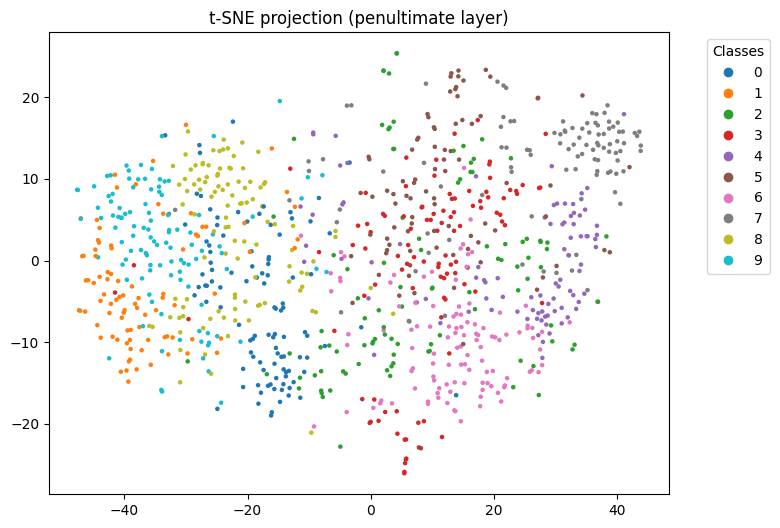

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


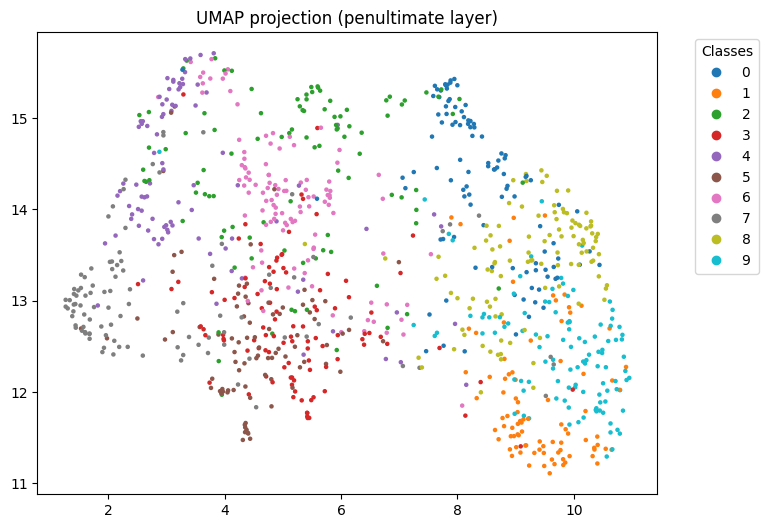

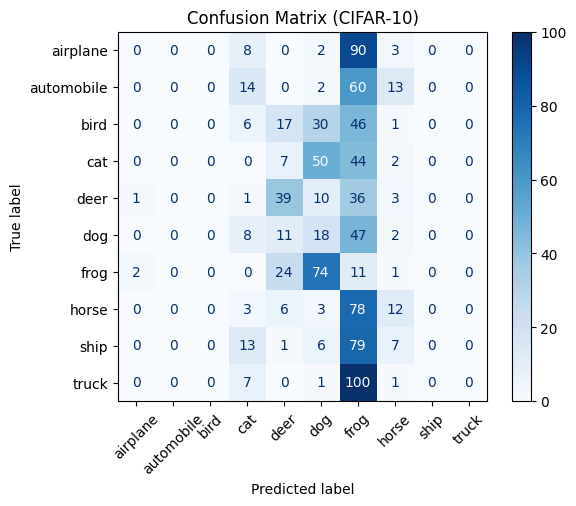

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]



Training ResNet-18 (Pretrained + FC only)...
Epoch [1/3] Train Acc: 50.34%, Val Acc: 67.20%
Epoch [2/3] Train Acc: 73.70%, Val Acc: 72.20%
Epoch [3/3] Train Acc: 76.64%, Val Acc: 74.10%

Training ResNet-152 (Pretrained + FC only)...
Epoch [1/3] Train Acc: 61.48%, Val Acc: 75.90%
Epoch [2/3] Train Acc: 78.26%, Val Acc: 76.00%
Epoch [3/3] Train Acc: 80.76%, Val Acc: 76.50%


In [13]:
model152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
model152.fc = nn.Linear(model152.fc.in_features, 10).to(device)
model152 = model152.to(device)

tsne_vs_umap(model152, val_loader)
plot_confusion_matrix(model152, val_loader)
compare_resnets()